# Salary prediction using resume data

# Data preparation

In [1]:
import numpy as np
import pandas as pd
import re, tqdm
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
from collections import Counter

In [2]:
data = pd.read_csv('/content/drive/MyDrive/conv nn/salary.csv')
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


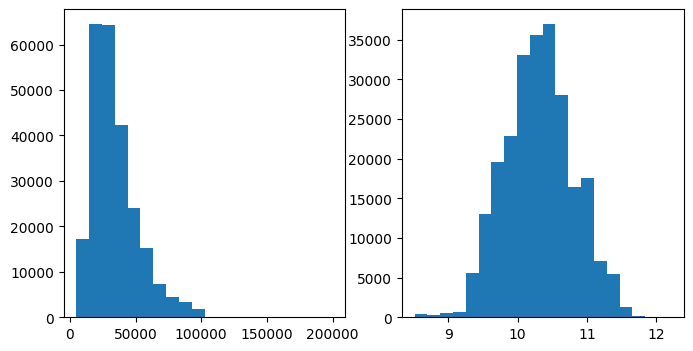

In [3]:
#масштабирование таргета
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

In [4]:
#отбор признаков
text_columns = ['Title', 'FullDescription']
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = 'Log1pSalary'


#заполнение пропусков
data[categorical_columns] = data[categorical_columns].fillna('NaN')

In [5]:
#создание токенизатора
tokenizer = nltk.tokenize.WordPunctTokenizer()

def tokenize_(x):
    return ' '.join(tokenizer.tokenize(str(x))).lower()

#токенизация текстовых признаков
for col in text_columns:
    data[col] = data[col].apply(tokenize_)

In [6]:
#Подсчет уникальных слов в корпусе
corpus = []
for col in text_columns:
    for obj in data[col]:
        corpus += obj.split()

In [7]:
token_counts = Counter(corpus)
token_counts

Counter({'engineering': 68563,
         'systems': 77071,
         'analyst': 34427,
         'stress': 1855,
         'engineer': 94623,
         'glasgow': 3333,
         'modelling': 6534,
         'and': 2657388,
         'simulation': 1314,
         '/': 554003,
         'mathematical': 1033,
         'modeller': 551,
         'pioneer': 381,
         ',': 2318606,
         'miser': 8,
         'water': 8259,
         'industry': 59732,
         'senior': 87513,
         'subsea': 1237,
         'pipeline': 3009,
         'integrity': 4456,
         'recruitment': 123310,
         'consultant': 44396,
         'industrial': 9498,
         'commercial': 56187,
         'driv': 9,
         'construction': 16679,
         'technical': 91480,
         'trades': 1190,
         'labour': 2069,
         'cables': 342,
         'trainee': 7805,
         'mortgage': 3564,
         'advisor': 16299,
         'east': 20244,
         'midlands': 11141,
         'project': 102963,
         'ph

In [8]:
#выбор токенов, которые встречаются определенное минимальное количество раз
min_count = 10

tokens = sorted([t for t, c in token_counts.items() if c >= min_count])

# Добавление специальных токенов для неизвестных слов и пропусков
UNK, PAD = 'UNK', 'PAD'
tokens += [UNK, PAD]

In [9]:
len(tokens)

34158

In [10]:
#словарь токенов формата имя_токена:индекс
token_to_id = {}
for i, t in dict(enumerate(tokens)).items():
    token_to_id[t] = i

In [11]:
#индексы неизвестного токена и токена отступа
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

#функция представления предложений в качестве матрицы
def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float('inf'))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [12]:
as_matrix(data['Title'][:10:3].values)

array([[10805, 30159,  2164, 34157, 34157, 34157],
       [10805, 30159,  2164,   195, 19173, 20040],
       [27643, 29672, 23337, 16071, 10802, 34157],
       [29672,  5094, 10802, 34157, 34157, 34157]], dtype=int32)

In [13]:
data['Title'][:10:3].values

array(['engineering systems analyst',
       'engineering systems analyst / mathematical modeller',
       'senior subsea pipeline integrity engineer',
       'subsea cables engineer'], dtype=object)

In [14]:
#сокращение имен компаний до тысячи самых популярных
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")


#кодирование категориальных признаков
from sklearn.feature_extraction import DictVectorizer

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [15]:
data[categorical_columns].loc[:2]

,Category,Company,LocationNormalized,ContractType,ContractTime
0,Engineering Jobs,Gregory Martin International,Dorking,NaN,permanent
1,Engineering Jobs,Gregory Martin International,Glasgow,NaN,permanent
2,Engineering Jobs,Gregory Martin International,Hampshire,NaN,permanent


In [16]:
data[categorical_columns].loc[:2].apply(dict)

,0
Category,"{0: 'Engineering Jobs', 1: 'Engineering Jobs',..."
Company,"{0: 'Gregory Martin International', 1: 'Gregor..."
LocationNormalized,"{0: 'Dorking', 1: 'Glasgow', 2: 'Hampshire'}"
ContractType,"{0: 'NaN', 1: 'NaN', 2: 'NaN'}"
ContractTime,"{0: 'permanent', 1: 'permanent', 2: 'permanent'}"


In [17]:
from sklearn.feature_extraction import DictVectorizer
categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit_transform(data[categorical_columns].loc[:2].apply(dict))

array([[0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]],
      dtype=float32)

In [18]:
#деление на тренировочную и тестовую выборку
data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

import torch
import torch.nn as nn
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'

#преобразование батча датасета в тензор
def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors



#создание батча
#параметр word_dropout - заменяет индекс токена на UNK_IX с заданной вероятностью
#возвращает словарь {'title' : int64[batch, title_max_len]}
def make_batch(data, max_len=None, word_dropout=0, device=device):

    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))

    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)

    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values

    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

# Model architecture

In [19]:
test_batch = make_batch(data_train[:20], max_len=20)
test_batch

{'Title': tensor([[27643, 29891, 33672, 34157, 34157, 34157, 34157, 34157, 34157, 34157,
          34157, 34157],
         [29237,   195, 19173, 20040, 15552, 23160,  4049, 34157, 34157, 34157,
          34157, 34157],
         [10607, 30410, 17744,    31,  8703, 29155,    63, 34157, 34157, 34157,
          34157, 34157],
         [ 7572, 16688, 10802, 18369,   156,  3956,  8416, 34157, 34157, 34157,
          34157, 34157],
         [ 9893, 34157, 34157, 34157, 34157, 34157, 34157, 34157, 34157, 34157,
          34157, 34157],
         [32750,    80,  1812, 26343, 30477, 33838,    80, 34157, 34157, 34157,
          34157, 34157],
         [13276, 18862, 19444, 26165, 19035, 14135, 34157, 34157, 34157, 34157,
          34157, 34157],
         [29367,  7433, 34156,   195, 32393,  9893, 34157, 34157, 34157, 34157,
          34157, 34157],
         [30151, 30688, 18156,   156, 16694,   156, 15064,   156,  8073, 16535,
          34157, 34157],
         [ 8186, 27744,  1581, 34098, 22587, 3

In [20]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()
        self.emb = nn.Embedding(len(tokens),32, device=device)

        self.seq_title = nn.Sequential(
            nn.Conv1d(32, 64, 3, device=device),
        )

        self.seq_desc = nn.Sequential(
            nn.Conv1d(32, 64, 3, device=device)
        )

        self.seq_cat = nn.Linear(15, 15, device=device)
        self.last_linear = nn.Linear(15 + 64 + 64, 1, device=device)

    def forward(self, batch):
        #извлекаем из батча два текстовых признака и категориальные
        title_batch = batch['Title']
        desc_batch = batch['FullDescription']
        cat_batch = batch['Categorical']

        #предобработка title
        #получение эмбеддингов
        title_batch = self.emb(title_batch)

        title_batch = title_batch.permute(0,2,1)
        title_batch = self.seq_title(title_batch)

        #maxpooling
        title_batch = torch.max(title_batch, dim=-1).values
        # print('title:', title_batch.shape)

        #предобработка full descriprion
        #получение эмбеддингов
        desc_batch = self.emb(desc_batch)

        desc_batch = desc_batch.permute(0,2,1)
        desc_batch = self.seq_desc(desc_batch)

        #maxpooling
        desc_batch = torch.max(desc_batch, dim=-1).values
        # print('desc:', desc_batch.shape)

        #предобработка категориальных признаков
        cat_batch = self.seq_cat(cat_batch)

        #соединение векторов с логитами текстовых и категориальных признаков
        concat = torch.cat([title_batch, desc_batch, cat_batch], dim=1)
        # print('con shape:', concat.shape)

        out = self.last_linear(concat)

        return out.squeeze()

In [21]:
model = SalaryPredictor().to(device)
batch = make_batch(data_train[:100], device=device)
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])

dummy_pred, dummy_loss

(tensor([ 0.1496,  0.0515,  0.3251,  0.1624,  0.0893,  0.3907,  0.2502,  0.2217,
          0.3098, -0.0560,  0.2985,  0.3904,  0.1597,  0.1705,  0.0887, -0.0666,
          0.2435,  0.3022,  0.1226, -0.0797,  0.2852, -0.0348,  0.0212,  0.0982,
          0.2700, -0.0440, -0.0032, -0.0177,  0.1445,  0.1691,  0.2206,  0.1394,
          0.1107,  0.1248,  0.0827,  0.4346, -0.0396, -0.0715,  0.1256,  0.3783,
          0.1046,  0.1979,  0.5420, -0.0021,  0.0676,  0.1386, -0.1783,  0.2093,
          0.0598,  0.2981,  0.2778,  0.1206,  0.1501,  0.3584,  0.2806,  0.0574,
          0.2457,  0.1409,  0.2638,  0.5742,  0.2219,  0.1274,  0.0878,  0.3527,
          0.1304,  0.1697,  0.1059,  0.0867, -0.0124,  0.0502,  0.1519,  0.0323,
          0.0405,  0.2626,  0.3922,  0.2033,  0.0918,  0.2919, -0.0999,  0.0405,
          0.1639,  0.2376,  0.2266,  0.1046,  0.2443,  0.0772,  0.2111,  0.0366,
          0.2504,  0.5037,  0.5420,  0.1841, -0.0365,  0.3584,  0.1826,  0.0961,
          0.1428,  0.1888,  

In [34]:
#итерация минибатчей в рандомном порядке
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch

        if not cycle: break

#вывод метрик
BATCH_SIZE = 16
EPOCHS = 10


def print_metrics(model, data, batch_size=BATCH_SIZE, name="", device=torch.device('cpu'), **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae

In [35]:
from tqdm.auto import tqdm

model = SalaryPredictor().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

In [36]:
for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        del batch
    print_metrics(model, data_val, device=device)



epoch: 0


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.17207
Mean absolute error: 0.32527
epoch: 1


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.14351
Mean absolute error: 0.29214
epoch: 2


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.13379
Mean absolute error: 0.27911
epoch: 3


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.13210
Mean absolute error: 0.28190
epoch: 4


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.12207
Mean absolute error: 0.26565
epoch: 5


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.12715
Mean absolute error: 0.27739
epoch: 6


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.11839
Mean absolute error: 0.26491
epoch: 7


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.11347
Mean absolute error: 0.25783
epoch: 8


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.11289
Mean absolute error: 0.25438
epoch: 9


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.11103
Mean absolute error: 0.25554
